# Employee Utilization Prediction Model

## Problem Description

Every organization wants to keep a track of the available employee utilization in advance. This helps in proper planning of resource allocation to different projects and also helps to forecast the revenue of the organization. As a result, employee utilization forecast needs to be shared with different sectors in the organization for a few quarters in advance. Forecasts are usually generated manually considering vacation and holiday calendars. The process is quite cumbersome involving huge amount of manual effort and time. Also it has been observed that the forecasted figures rarely comes out to be close to the actual utilization figures.

## Model used 

Seasonal ARIMA model has been used in Python to solve the problem and create a model which has given close to 98% accuracy while comparing actual vs predicted employee utilization.

## Python Code

In [1]:
# first import the essential libraries

import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import cufflinks as cf
cf.go_offline()
import warnings
import datetime as dt

In [3]:
# import the input data

df_ilc_holidays = pd.read_excel(r'C:\Users\DebdinnyaBanerjee\ILC Forecast\Input Files\CleanedData_BI_20200806.xlsx')
df_ilc_holidays

,Weekending Date,Mean hours,Chargeable hours,Actual Util%,Head Count,Available hours,Holiday
0,2017-12-29,36.227397,2644.6,90.568493,73,2920.0,0.00
1,2018-01-05,42.251899,3337.9,105.629747,79,3160.0,0.00
2,2018-01-12,43.544304,3440.0,108.860759,79,3160.0,0.00
3,2018-01-19,41.341772,3266.0,103.354430,79,3160.0,0.00
4,2018-01-26,30.132911,2380.5,75.332278,79,3160.0,1.75
...,...,...,...,...,...,...,...
152,2020-11-27,NaN,NaN,NaN,83,NaN,0.00
153,2020-12-04,NaN,NaN,NaN,83,NaN,0.00
154,2020-12-11,NaN,NaN,NaN,83,NaN,0.00
155,2020-12-18,NaN,NaN,NaN,83,NaN,0.00


In [4]:
# first index for current year
curr_year = dt.date.today().year
first_day_cur_year = dt.date(curr_year,1,1).strftime('%Y-%m-%d')
first_index_cur_year = df_ilc_holidays[df_ilc_holidays['Weekending Date']>first_day_cur_year]['Weekending Date'].head(1).item()
first_index_cur_year

'2020-01-03'

In [5]:
# set the Weekending Date as the index

df_ilc_holidays.set_index('Weekending Date',inplace=True)
df_ilc_holidays

,Mean hours,Chargeable hours,Actual Util%,Head Count,Available hours,Holiday
Weekending Date,,,,,,
2017-12-29,36.227397,2644.6,90.568493,73,2920.0,0.00
2018-01-05,42.251899,3337.9,105.629747,79,3160.0,0.00
2018-01-12,43.544304,3440.0,108.860759,79,3160.0,0.00
2018-01-19,41.341772,3266.0,103.354430,79,3160.0,0.00
2018-01-26,30.132911,2380.5,75.332278,79,3160.0,1.75
...,...,...,...,...,...,...
2020-11-27,NaN,NaN,NaN,83,NaN,0.00
2020-12-04,NaN,NaN,NaN,83,NaN,0.00
2020-12-11,NaN,NaN,NaN,83,NaN,0.00


In this dataset, we will come across some records where the Mean hours has been given. This is the actual utilization data. While for some others, the mean hours has been set to null and employee headcount and holiday factor has been given. These will be used for the forecast data.

In [8]:
# find out first and last weeks for actual hours for entire dataset
df_actuals_first_index = df_ilc_holidays[df_ilc_holidays['Mean hours'].notna()]['Mean hours'].first_valid_index()
df_actuals_first_index

'2017-12-29'

In [9]:
df_actuals_last_index = df_ilc_holidays[df_ilc_holidays['Mean hours'].notna()]['Mean hours'].last_valid_index()
df_actuals_last_index

'2020-07-31'

In [10]:
# similarly find out first and last week for prediction data
df_predictions_first_index = df_ilc_holidays[df_ilc_holidays['Mean hours'].isna()]['Holiday'].first_valid_index()
df_predictions_first_index

'2020-08-07'

In [11]:
df_predictions_last_index = df_ilc_holidays[df_ilc_holidays['Mean hours'].isna()]['Holiday'].last_valid_index()
df_predictions_last_index

'2020-12-25'

In [12]:
# plot the graph for every actual data
df_ilc_holidays.loc[df_actuals_first_index:df_actuals_last_index]['Mean hours'].iplot(title='ILC Claimed per week',xTitle='Week',yTitle='Efforts in hours')

In [13]:
# find out the parameters for the SARIMAX model
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [14]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [15]:
# find out the best fit model
# the model with the lowest AIC value is the best fit model
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.SARIMAX(endog=df_ilc_holidays.loc[df_actuals_first_index:df_actuals_last_index]['Mean hours'],exog=df_ilc_holidays.loc[df_actuals_first_index:df_actuals_last_index]['Holiday'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        print('SARIMAX{}x{}12 - AIC {}'.format(param,param_seasonal,results.aic))

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC 1377.3769472318659
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC 1147.2726961185729
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC 481.54878313535454
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC 380.68991792502953
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC 506.64298598286376
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC 422.2382661735097
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC 397.81697419623686
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC 376.7816547752031
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC 1217.3893714542655
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC 988.1744109582526
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC 471.3685933681163
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC 375.46407028356043
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC 499.6464437177582
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC 419.44466254440226
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC 397.95517000440697
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC 373.5831865018198
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC 485.43168916825664
SARIMAX(0, 1, 0)x(0,

In [16]:
# SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 - AIC 373.2955705652238
mod = sm.tsa.SARIMAX(endog=df_ilc_holidays.loc[df_actuals_first_index:df_actuals_last_index]['Mean hours'],exog=df_ilc_holidays.loc[df_actuals_first_index:df_actuals_last_index]['Holiday'],order=(1,1,1),seasonal_order=(0,1,1,12),enforce_invertibility=False,enforce_stationarity=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Mean hours   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -181.648
Date:                            Wed, 09 Sep 2020   AIC                            373.296
Time:                                    18:25:38   BIC                            386.752
Sample:                                12-29-2017   HQIC                           378.753
                                     - 07-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -7.9535      0.302    -26.302      0.000      -8.546      -7.361
ar.L1          0.1919      0.092   

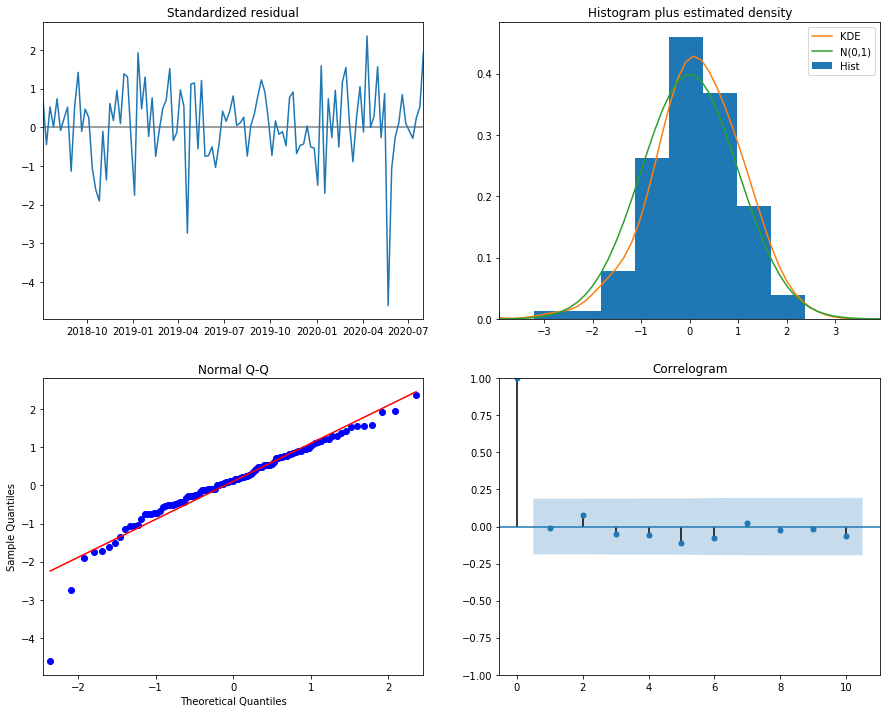

In [17]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

### Test the model using in-sample data

In [18]:
# make ILC predictions for 2019 using in-sample data
pred_2019 = results.get_prediction(start='2019-01-04',end='2019-12-27')
pred_ci = pred_2019.conf_int()

In [19]:
pred_ci

,lower Mean hours,upper Mean hours
2019-01-04,40.155867,45.316083
2019-01-11,39.054782,44.206062
2019-01-18,38.715951,43.859276
2019-01-25,35.084567,40.220762
2019-02-01,40.387808,45.517580
2019-02-08,40.023449,45.147401
2019-02-15,41.058839,46.177494
2019-02-22,40.257284,45.371099
2019-03-01,40.631635,45.687593
2019-03-08,40.616874,45.664077


In [21]:
df_ilc_2019 = pd.DataFrame()
df_ilc_2019['Actual'] = df_ilc_holidays.loc['2019-01-04':'2019-12-27']['Mean hours']
df_ilc_2019['Mean Predictions'] = pred_2019.predicted_mean
df_ilc_2019['Deviations'] = np.abs(df_ilc_2019['Actual']-df_ilc_2019['Mean Predictions'])
df_ilc_2019['Lower Predicted Hours'] = pred_ci['lower Mean hours']
df_ilc_2019['Upper Predicted Hours'] = pred_ci['upper Mean hours']
df_ilc_2019['Root mean square err 2019 (Mean Weekly ILC)'] = np.sqrt((df_ilc_2019['Deviations']**2).mean())
df_ilc_2019

,Actual,Mean Predictions,Deviations,Lower Predicted Hours,Upper Predicted Hours,Root mean square err 2019 (Mean Weekly ILC)
Weekending Date,,,,,,
2019-01-04,40.424658,42.735975,2.311317,40.155867,45.316083,1.083393
2019-01-11,44.164384,41.630422,2.533961,39.054782,44.206062,1.083393
2019-01-18,41.916667,41.287614,0.629053,38.715951,43.859276,1.083393
2019-01-25,39.361111,37.652664,1.708447,35.084567,40.220762,1.083393
2019-02-01,42.643836,42.952694,0.308859,40.387808,45.517580,1.083393
2019-02-08,43.583333,42.585425,0.997908,40.023449,45.147401,1.083393
2019-02-15,42.635135,43.618167,0.983031,41.058839,46.177494,1.083393
2019-02-22,42.702703,42.814192,0.111489,40.257284,45.371099,1.083393
2019-03-01,43.786667,43.159614,0.627053,40.631635,45.687593,1.083393


Out of 45 hours that we consider for employee timesheet every week, RMSE is only 1.08. It means the error is very less. Our model is making very close predictions.

In [22]:
# lets plot the actual vs predicted data for the entire year 2019

df_ilc_2019[['Actual','Mean Predictions']].iplot(title='ILC for year 2019',xTitle='Week',yTitle='Efforts in hours')

In [23]:
# start with the predictions for current year 2020
# first we will try with in-sample data
pred_2020 = results.get_prediction(start=first_index_cur_year,end=df_actuals_last_index)
pred_ci = pred_2020.conf_int()

In [24]:
pred_ci

,lower Mean hours,upper Mean hours
2020-01-03,40.058139,44.872894
2020-01-10,39.941758,44.754755
2020-01-17,38.800358,43.611688
2020-01-24,34.084048,38.893796
2020-01-31,40.639392,45.432410
2020-02-07,40.432000,45.222817
2020-02-14,40.438537,45.227282
2020-02-21,40.099867,44.886656
2020-02-28,39.853387,44.638329
2020-03-06,40.825188,45.608383


In [25]:
df_ilc_2020 = pd.DataFrame()
df_ilc_2020['Actual'] = df_ilc_holidays.loc['2020-01-03':'2020-07-31']['Mean hours']
df_ilc_2020['Mean predictions'] = pred_2020.predicted_mean
df_ilc_2020['Lower Predicted Hours'] = pred_ci['lower Mean hours']
df_ilc_2020['Upper Predicted Hours'] = pred_ci['upper Mean hours']
df_ilc_2020

,Actual,Mean predictions,Lower Predicted Hours,Upper Predicted Hours
Weekending Date,,,,
2020-01-03,40.625000,42.465517,40.058139,44.872894
2020-01-10,44.304878,42.348257,39.941758,44.754755
2020-01-17,39.111111,41.206023,38.800358,43.611688
2020-01-24,37.395062,36.488922,34.084048,38.893796
2020-01-31,42.712500,43.035901,40.639392,45.432410
2020-02-07,44.000000,42.827409,40.432000,45.222817
2020-02-14,42.209877,42.832909,40.438537,45.227282
2020-02-21,43.925000,42.493262,40.099867,44.886656
2020-02-28,44.135802,42.245858,39.853387,44.638329


In [26]:
rmse_2020 = np.sqrt(((df_ilc_2020['Actual']-df_ilc_2020['Mean predictions'])**2).mean())
rmse_2020

1.5698146006450886

Again RMSE is only 1.56 out of actual 45 hours for 2020. So model is making close predictions.

In [27]:
# make predictions for the remaining weeks of the year

# count the number of remaining weeks for the year
count = len(dict(df_ilc_holidays.loc[df_predictions_first_index:df_predictions_last_index]['Holiday'].items()))
forecast_2020 = results.get_forecast(steps=count,exog=df_ilc_holidays.loc[df_predictions_first_index:df_predictions_last_index]['Holiday'])
forecast_2020.predicted_mean

2020-08-07    43.303445
2020-08-14    39.818448
2020-08-21    42.609472
2020-08-28    42.855747
2020-09-04    42.858939
2020-09-11    42.508704
2020-09-18    42.887795
2020-09-25    42.886340
2020-10-02    34.885497
2020-10-09    42.929939
2020-10-16    43.191805
2020-10-23    36.770472
2020-10-30    34.853840
2020-11-06    41.652365
2020-11-13    42.520553
2020-11-20    34.825874
2020-11-27    42.785010
2020-12-04    42.435239
2020-12-11    42.814418
2020-12-18    42.812981
2020-12-25    34.812141
Freq: W-FRI, dtype: float64

In [28]:
pred_ci_forecast = forecast_2020.conf_int()

In [29]:
df_2020 = pd.DataFrame()
df_2020['Mean predictions'] = forecast_2020.predicted_mean
df_2020['Lower Predicted Hours'] = pred_ci_forecast['lower Mean hours']
df_2020['Upper Predicted Hours'] = pred_ci_forecast['upper Mean hours']
df_2020

,Mean predictions,Lower Predicted Hours,Upper Predicted Hours
2020-08-07,43.303445,40.938044,45.668846
2020-08-14,39.818448,37.399788,42.237108
2020-08-21,42.609472,40.186940,45.032003
2020-08-28,42.855747,40.432702,45.278792
2020-09-04,42.858939,40.435804,45.282073
2020-09-11,42.508704,40.085552,44.931856
2020-09-18,42.887795,40.464640,45.310950
2020-09-25,42.886340,40.463185,45.309496
2020-10-02,34.885497,32.462342,37.308653
2020-10-09,42.929939,40.509026,45.350852


In [30]:
# concat the 2 dataframes
df_concat = pd.concat([df_ilc_2020,df_2020], sort=False)
df_concat

,Actual,Mean predictions,Lower Predicted Hours,Upper Predicted Hours
2020-01-03,40.625000,42.465517,40.058139,44.872894
2020-01-10,44.304878,42.348257,39.941758,44.754755
2020-01-17,39.111111,41.206023,38.800358,43.611688
2020-01-24,37.395062,36.488922,34.084048,38.893796
2020-01-31,42.712500,43.035901,40.639392,45.432410
2020-02-07,44.000000,42.827409,40.432000,45.222817
2020-02-14,42.209877,42.832909,40.438537,45.227282
2020-02-21,43.925000,42.493262,40.099867,44.886656
2020-02-28,44.135802,42.245858,39.853387,44.638329
2020-03-06,43.365854,43.216785,40.825188,45.608383


In [31]:
# as we see some index as Dates while some others as DateTime, we will convert it into date
df_concat.index = pd.to_datetime(df_concat.index)
df_concat.index.name = 'Weekending Date'
df_concat

,Actual,Mean predictions,Lower Predicted Hours,Upper Predicted Hours
Weekending Date,,,,
2020-01-03,40.625000,42.465517,40.058139,44.872894
2020-01-10,44.304878,42.348257,39.941758,44.754755
2020-01-17,39.111111,41.206023,38.800358,43.611688
2020-01-24,37.395062,36.488922,34.084048,38.893796
2020-01-31,42.712500,43.035901,40.639392,45.432410
2020-02-07,44.000000,42.827409,40.432000,45.222817
2020-02-14,42.209877,42.832909,40.438537,45.227282
2020-02-21,43.925000,42.493262,40.099867,44.886656
2020-02-28,44.135802,42.245858,39.853387,44.638329


In [32]:
df_concat[['Actual','Mean predictions']].iplot(title='Actual vs Forecast ILC for year 2020',xTitle='Week',yTitle='Efforts in hours')

In [33]:
df_concat['Head Count'] = df_ilc_holidays.loc[first_index_cur_year:df_predictions_last_index]['Head Count']
df_concat['Actual Chargeable Hours'] = df_concat['Actual'] * df_concat['Head Count']
df_concat['Available Hours'] = df_concat['Head Count'] * 40
df_concat['Actual Util %'] = df_concat['Actual Chargeable Hours']/df_concat['Available Hours'] * 100
df_concat['Predicted Chargeable hours'] = df_concat['Mean predictions'] * df_concat['Head Count']
df_concat['Predicted Util Mean%'] = df_concat['Predicted Chargeable hours']/df_concat['Available Hours'] * 100
df_concat['Predicted Util Lower%'] = df_concat['Lower Predicted Hours']* df_concat['Head Count']/df_concat['Available Hours'] * 100
df_concat['Predicted Util Upper%'] = df_concat['Upper Predicted Hours']* df_concat['Head Count']/df_concat['Available Hours'] * 100
df_concat['Root mean square err 2020 (Mean Weekly ILC)'] = rmse_2020
df_concat['Diff'] = df_concat['Actual'] - df_concat['Mean predictions']
df_concat

,Actual,Mean predictions,Lower Predicted Hours,Upper Predicted Hours,Head Count,Actual Chargeable Hours,Available Hours,Actual Util %,Predicted Chargeable hours,Predicted Util Mean%,Predicted Util Lower%,Predicted Util Upper%,Root mean square err 2020 (Mean Weekly ILC),Diff
Weekending Date,,,,,,,,,,,,,,
2020-01-03,40.625000,42.465517,40.058139,44.872894,80,3250.0,3200,101.562500,3397.241331,106.163792,100.145347,112.182236,1.569815,-1.840517
2020-01-10,44.304878,42.348257,39.941758,44.754755,82,3633.0,3280,110.762195,3472.557038,105.870641,99.854396,111.886887,1.569815,1.956621
2020-01-17,39.111111,41.206023,38.800358,43.611688,81,3168.0,3240,97.777778,3337.687833,103.015057,97.000894,109.029219,1.569815,-2.094912
2020-01-24,37.395062,36.488922,34.084048,38.893796,81,3029.0,3240,93.487654,2955.602692,91.222305,85.210120,97.234490,1.569815,0.906140
2020-01-31,42.712500,43.035901,40.639392,45.432410,80,3417.0,3200,106.781250,3442.872064,107.589752,101.598479,113.581025,1.569815,-0.323401
2020-02-07,44.000000,42.827409,40.432000,45.222817,79,3476.0,3160,110.000000,3383.365290,107.068522,101.080000,113.057043,1.569815,1.172591
2020-02-14,42.209877,42.832909,40.438537,45.227282,81,3419.0,3240,105.524691,3469.465658,107.082273,101.096343,113.068204,1.569815,-0.623033
2020-02-21,43.925000,42.493262,40.099867,44.886656,80,3514.0,3200,109.812500,3399.460928,106.233154,100.249667,112.216641,1.569815,1.431738
2020-02-28,44.135802,42.245858,39.853387,44.638329,81,3575.0,3240,110.339506,3421.914487,105.614645,99.633467,111.595823,1.569815,1.889945


In [34]:
df_concat.to_csv('BI Actual vs Forecast ILC 2020_20200806.csv')